# Callback: User cuts

Consider again the Time Constrained Fixed Charge Multi-Commodity Flow Problem and let's add the strong flow constraints

$$
x_e^k \leq D^k y_e
$$

for some $k \in K, e \in E$.

Use the callback routine to add cuts when violated.

In [1]:
# data

from flowty import (
    Model,
    xsum,
    LinExpr,
    OptimizationStatus,
    CallbackModel,
    Where,
)

K = 10

o = [7, 5, 3, 3, 1, 9, 2, 7, 5, 8]
d = [5, 9, 1, 6, 7, 3, 0, 0, 0, 7]
obj = [
    100.0,
    54.0,
    45.0,
    18.0,
    100.0,
    13.0,
    92.0,
    13.0,
    93.0,
    100.0,
    27.0,
    76.0,
    11.0,
    25.0,
    100.0,
    95.0,
    50.0,
    100.0,
    34.0,
    72.0,
    59.0,
    100.0,
    41.0,
    73.0,
    100.0,
    96.0,
    22.0,
    100.0,
    41.0,
    78.0,
    30.0,
    100.0,
    50.0,
    100.0,
    48.0,
]
edges = [
    (0, 1),
    (0, 9),
    (0, 7),
    (0, 6),
    (1, 2),
    (1, 3),
    (1, 6),
    (1, 8),
    (1, 7),
    (2, 3),
    (2, 1),
    (2, 0),
    (2, 6),
    (2, 9),
    (3, 4),
    (3, 2),
    (3, 9),
    (4, 5),
    (4, 1),
    (4, 7),
    (4, 2),
    (5, 6),
    (5, 9),
    (5, 7),
    (6, 7),
    (6, 0),
    (6, 8),
    (7, 8),
    (7, 2),
    (7, 6),
    (7, 1),
    (8, 9),
    (8, 5),
    (9, 0),
    (9, 5),
]
time = [
    20.0,
    8.201681,
    12.605042,
    12.403361,
    20.0,
    14.823529,
    11.428571,
    6.016807,
    12.201681,
    20.0,
    18.621849,
    4.806723,
    8.0,
    17.411765,
    20.0,
    3.630252,
    10.823529,
    20.0,
    4.201681,
    18.016807,
    17.613445,
    20.0,
    10.218487,
    13.210084,
    20.0,
    9.613445,
    19.226891,
    20.0,
    11.428571,
    12.0,
    8.605042,
    20.0,
    10.016807,
    20.0,
    12.605042,
]
T = [
    29.566387,
    12.262185,
    26.702521,
    13.956303,
    14.642017,
    59.092437,
    5.768067,
    19.482353,
    36.262185,
    27.872269,
]
f = [
    595.0,
    244.0,
    375.0,
    369.0,
    595.0,
    441.0,
    340.0,
    179.0,
    363.0,
    595.0,
    554.0,
    143.0,
    238.0,
    518.0,
    595.0,
    108.0,
    322.0,
    595.0,
    125.0,
    536.0,
    524.0,
    595.0,
    304.0,
    393.0,
    595.0,
    286.0,
    572.0,
    595.0,
    340.0,
    357.0,
    256.0,
    595.0,
    298.0,
    595.0,
    375.0,
]
u = [
    613.0,
    81.0,
    151.0,
    223.0,
    613.0,
    198.0,
    115.0,
    215.0,
    193.0,
    613.0,
    265.0,
    129.0,
    143.0,
    129.0,
    613.0,
    232.0,
    179.0,
    613.0,
    73.0,
    232.0,
    276.0,
    613.0,
    101.0,
    173.0,
    613.0,
    198.0,
    221.0,
    613.0,
    134.0,
    134.0,
    201.0,
    613.0,
    240.0,
    613.0,
    156.0,
]
D = [71.0, 32.0, 78.0, 40.0, 53.0, 80.0, 57.0, 72.0, 57.0, 73.0]

In [2]:
# TCFCMCF

m = Model()

# create graphs per commodity
g = [
    m.addGraph(obj=obj, edges=edges, source=o[k], sink=d[k], L=D[k], U=D[k], type="C")
    for k in range(K)
]

# add transit time constraints to graphs
[
    m.addResourceDisposable(graph=g[k], consumptionType="E", weight=time, lb=0, ub=T[k])
    for k in range(K)
]

# demand constraints - redundant due to convexity constraints when adding graphs?
[
    m.addConstr(xsum(x for x in g[k].vars if x.source == g[k].source) == D[k])
    for k in range(K)
]

# design variables
y = [m.addVar(lb=0, ub=1, obj=f[e], type="B") for e, edge in enumerate(edges)]

# capacity constraints
[
    m.addConstr(
        xsum(x for k in range(K) for x in g[k].vars if x.edge == edge) <= u[e] * y[e]
    )
    for e, edge in enumerate(edges)
]


def callback(cb: CallbackModel, where: Where):
    if where == Where.PathMIPCuts:
        epsilon = 1e-4
        relax = cb.x

        for e, y_var in enumerate(y):
            edge = edges[e]

            for k in range(K):
                for x in g[k].vars:
                    if x.edge != edge:
                        continue

                    if relax[x.idx] > D[k] * relax[y_var.idx] + epsilon:
                        cb.addCut(x <= D[k] * y_var)
                        print("Adding a cut")


m.setCallback(callback)

status = m.optimize()

print(f"ObjectiveValue {m.objectiveValue}")

Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
Adding a cut
ObjectiveValue 74079.0


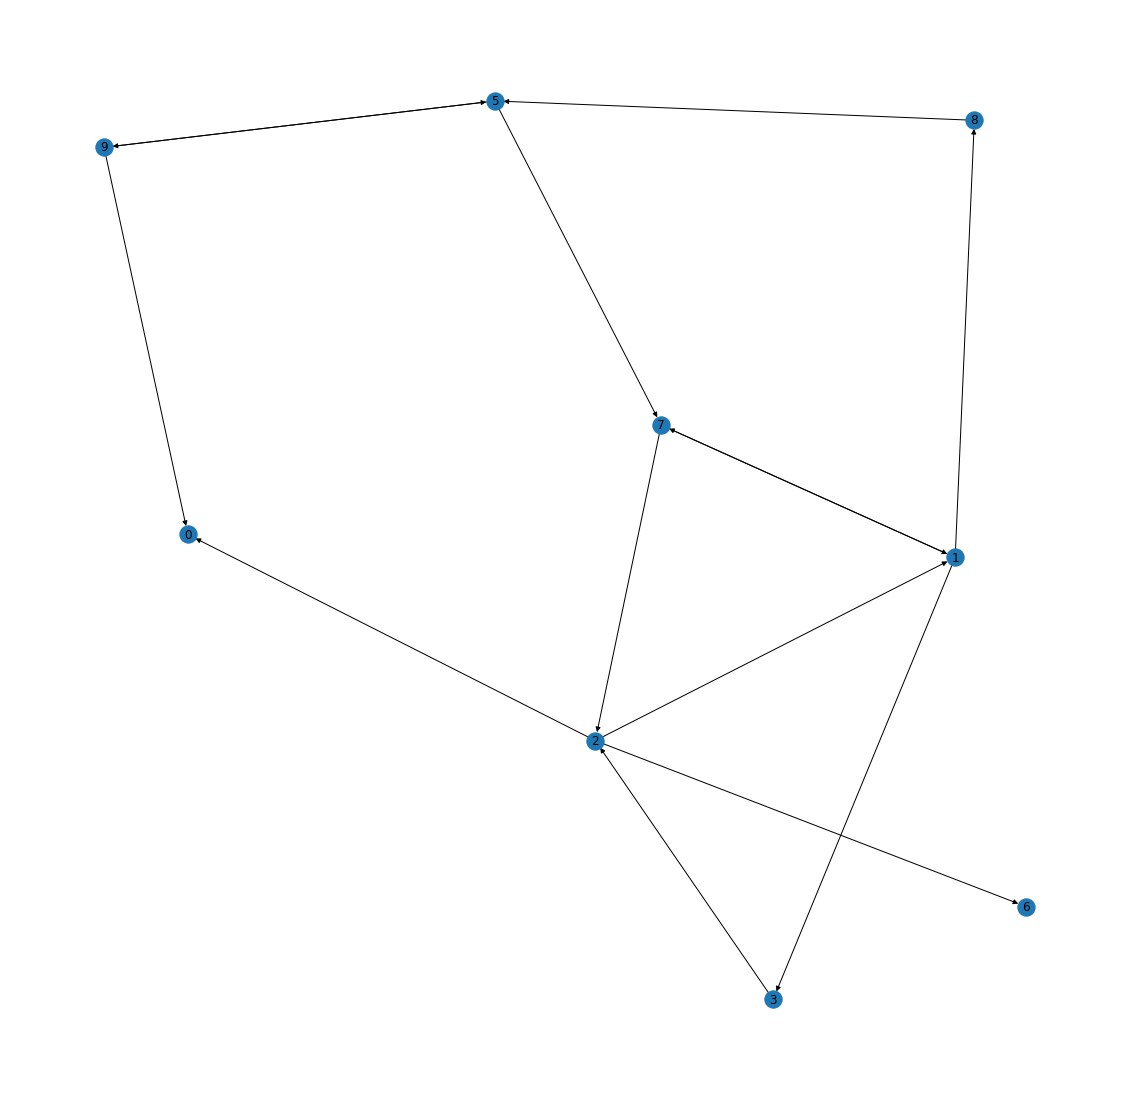

In [5]:
# display

# get the variables
xs = m.vars

# for var in xs:
#    if var.x > 0:
#        print(f"{var.idx} = {var.x}")

# display solution
import math
import networkx
import matplotlib
import matplotlib.pyplot as plt

if status == OptimizationStatus.Optimal or status == OptimizationStatus.Feasible:
    plt.figure(figsize=(20,20))
    edges = [
        var.edge
        for k in range(K)
        for var in g[k].vars
        if not math.isclose(var.x, 0, abs_tol=0.001)
    ]

    gn = networkx.DiGraph()
    gn.add_edges_from(edges)
    pos = networkx.kamada_kawai_layout(gn)

    networkx.draw_networkx_labels(gn, pos)

    networkx.draw(gn, pos)
    plt.show()